# Librerías utilizadas a lo largo del proyeto

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from imblearn.ensemble  import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTENC, SMOTE
from catboost import CatBoostClassifier
from sklearn.neighbors import BallTree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import optuna
import pickle
import time

d:\Python_Envs\torch311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargamos el dataset

In [2]:
df = pd.read_excel('data_with_weather_information.xlsx')

# Utilizando SMOTE para el Train Set

In [ ]:
SMOTE_df = df.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    SMOTE_df[col] = le.fit_transform(SMOTE_df[col])

# Separamos nuestro train y test sets por mascaras
train_mask = (SMOTE_df['sampling_date'].dt.year < 2025) & (SMOTE_df['sampling_date'].dt.year >= 2014)
test_mask  = SMOTE_df['sampling_date'].dt.year == 2025

# Columnas que no tomaremos en cuenta
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count',
    'month', 'year-month', 'sampling_date',
]

# Features que usaremos para predecir la severidad
features = [col for col in SMOTE_df.columns if col not in exclude_cols]

# Generamos nuestros train y test sets
X_train, y_train = SMOTE_df.loc[train_mask, features], SMOTE_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = SMOTE_df.loc[test_mask,  features], SMOTE_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

# Definimos las features categoricas
categorical_features = [
    X_train.columns.get_loc(col)
    for col in ['municipality', 'state', 'critical_season' ]
]

# Aplicamos SMOTENC
smote_nc = SMOTENC(
    categorical_features=categorical_features,
    random_state=42,
    sampling_strategy='auto'
)

# Generamos los train sets luego de SMOTENC
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [3]:
print("Antes de SMOTENC:")
print(y_train.value_counts(normalize=True))

print("\nDespues de SMOTENC:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Antes de SMOTENC:
severity_encoded
1    0.607012
0    0.371983
2    0.019409
3    0.001596
Name: proportion, dtype: float64

Despues de SMOTENC:
severity_encoded
0    0.25
2    0.25
1    0.25
3    0.25
Name: proportion, dtype: float64


In [4]:
# Creamos un dataFrame con la data sintetica
X_resampled_df = pd.DataFrame(X_resampled, columns=features)
y_resampled_df = pd.DataFrame(y_resampled, columns=['severity_encoded'])

# Combinamos los feature y target para ver las dimensiones del nuevo trainset
SMOTE_resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

SMOTE_resampled_df.shape

(1742924, 23)

In [9]:
chunk_size = 800000
output_file = 'SMOTE_resampled_train.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for i in range(0, len(SMOTE_resampled_df), chunk_size):
        chunk_df = SMOTE_resampled_df.iloc[i:i + chunk_size]
        sheet_name = f'Sheet_{i // chunk_size + 1}'
        chunk_df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ DataFrame con {len(SMOTE_resampled_df):,} filas exportado en Excel correctamente.")

✅ DataFrame con 1,742,924 filas exportado en Excel correctamente.


## LightGBM + Optuna + SMOTE

In [26]:
# Copiamos el train set luego del resampling
lgbm_df = SMOTE_resampled_df.copy()

# Columnas que no son features
exclude_cols = [
    'severity_encoded', 'tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date', 'municipality', 'state'
]

# Seleccionamos solos los features
features = [col for col in lgbm_df.columns if col not in exclude_cols]

X = lgbm_df[features]
y = lgbm_df['severity_encoded']


def objective_lgbm(trial):
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "num_class": 4,
        "class_weight": "balanced",
        "is_unbalance": False,
        "device_type": "gpu",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 120),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200),
        "min_gain_to_split": 0.001,
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "random_state": 42,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 150),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "verbose": -1,
        "force_col_wise" : True,
        "bagging_freq": 5,
    }

    model = LGBMClassifier(**params)
    model.fit(X, y)

    # Predicciones en test
    y_pred = model.predict(X_test[features])

    # Evaluación por F1 Macro en el test set
    f1_macro = f1_score(y_test, y_pred, average='macro')


    return f1_macro

study_name = "SMOTE_LightGBM_Optimization"
storage_name = f"sqlite:///{study_name}.db"

lgbm_study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction='maximize',
    load_if_exists=True
)


lgbm_study.optimize(objective_lgbm, n_trials=30)

print("\n\n✅ Mejores parámetros encontrados:")
print(lgbm_study.best_params)
print(f"✅ Mejor F1 Macro en test: {lgbm_study.best_value:.4f}")

[I 2025-11-01 22:04:44,544] Using an existing study with name 'SMOTE_LightGBM_Optimization' instead of creating a new one.
[I 2025-11-01 22:05:19,066] Trial 19 finished with value: 0.4346099706250123 and parameters: {'learning_rate': 0.04373914146931453, 'num_leaves': 62, 'max_depth': 3, 'feature_fraction': 0.8796413997894356, 'bagging_fraction': 0.9859871173148639, 'lambda_l1': 0.053848167315025286, 'lambda_l2': 3.173025241142264, 'min_child_samples': 128, 'n_estimators': 248, 'min_data_in_leaf': 143, 'min_gain_to_split': 0.02116881542156135}. Best is trial 19 with value: 0.4346099706250123.
[I 2025-11-01 22:05:56,206] Trial 20 finished with value: 0.4332683137383515 and parameters: {'learning_rate': 0.03808518361276278, 'num_leaves': 53, 'max_depth': 3, 'feature_fraction': 0.885443492250489, 'bagging_fraction': 0.9864162163803565, 'lambda_l1': 0.1170003174520391, 'lambda_l2': 3.184680570619044, 'min_child_samples': 120, 'n_estimators': 268, 'min_data_in_leaf': 149, 'min_gain_to_split



✅ Mejores parámetros encontrados:
{'learning_rate': 0.06135176595096744, 'num_leaves': 57, 'max_depth': 3, 'feature_fraction': 0.8365377773708654, 'bagging_fraction': 0.9732747345344976, 'lambda_l1': 0.3259595787450307, 'lambda_l2': 3.094387437597022, 'min_child_samples': 115, 'n_estimators': 246, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.00663956054949366}
✅ Mejor F1 Macro en test: 0.4378


In [27]:
lgbm_best_params = lgbm_study.best_params
lgbm_best_params

{'learning_rate': 0.06135176595096744,
 'num_leaves': 57,
 'max_depth': 3,
 'feature_fraction': 0.8365377773708654,
 'bagging_fraction': 0.9732747345344976,
 'lambda_l1': 0.3259595787450307,
 'lambda_l2': 3.094387437597022,
 'min_child_samples': 115,
 'n_estimators': 246,
 'min_data_in_leaf': 150,
 'min_gain_to_split': 0.00663956054949366}

In [30]:
lgbm_best_params = LGBMClassifier(
    boosting_type = "gbdt",
    objective = "multiclass",
    num_class = 4,
    class_weight = "balanced",
    is_unbalance = False,
    device_type = "gpu",
    min_gain_to_split = 0.001,  
    random_state = 42,
    verbose = -1,
    learning_rate= 0.06135176595096744,
    num_leaves= 57,
    max_depth= 3,
    feature_fraction= 0.8365377773708654,
    bagging_fraction= 0.9732747345344976,
    lambda_l1= 0.3259595787450307,
    lambda_l2= 3.094387437597022,
    min_child_samples= 115,
    n_estimators= 246,
    min_data_in_leaf = 150
    
)

lgbm_best_params.fit(X, y)

y_pred_lgbm_best = lgbm_best_params.predict(X_test[features])


print("Resultados para LightGBM después de usar Optuna y SMOTE:\n\n")
print(classification_report(y_test, y_pred_lgbm_best, digits=3))

print("\n\nMatriz de confusión con LightGBM y SMOTE:\n")
print(confusion_matrix(y_test,y_pred_lgbm_best))

y_pred_proba_lgbm_best_params = lgbm_best_params.predict_proba(X_test[features])

Resultados para LightGBM después de usar Optuna y SMOTE:


              precision    recall  f1-score   support

           0      0.252     0.175     0.206     24445
           1      0.759     0.809     0.783     82928
           2      0.160     0.273     0.202      2544
           3      0.395     0.955     0.559       110

    accuracy                          0.656    110027
   macro avg      0.391     0.553     0.437    110027
weighted avg      0.632     0.656     0.641    110027



Matriz de confusión con LightGBM y SMOTE:

[[ 4268 19963   201    13]
 [12258 67128  3442   100]
 [  396  1405   695    48]
 [    0     0     5   105]]


# PCA

In [ ]:
# Columnas que no son features
exclude_cols = [
    'severity_encoded', 'tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date', 'municipality', 'state'
]

# Seleccionamos solos los features
numerical_features = [
    'lat',
    'lon',
    'plantation_age',
    'square_area_imputed',
    'year',
    'day_of_year_sin',
    'day_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'month_sin',
    'month_cos',
    'distance_to_nearest_hotspot',
    'hotspots_within_5km',
    'precipitation',
    'avg_temp',
    'max_temp',
    'min_temp'
    ]

categorical_features = [
    'critical_season'
]

In [ ]:
# Iniciamos creando nuestros dataframes de features y clasificacion (severity_encoded)
X_pca = df[numerical_features + categorical_features]
y_pca = df['severity_encoded']

# Usamos OneHotEncoder nuevamente
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X_pca[categorical_features])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_features), index=X_pca.index)

In [ ]:
# Aplicamos scaler ya que PCA es susceptible a las magnitudes
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_pca[numerical_features])

X_num_df = pd.DataFrame(X_num_scaled, columns=numerical_features, index=X_pca.index)

In [ ]:
# Unimos  nuestros features numericos y categoricos en un solo dataFrame de nuevo
X_scaled = pd.concat([X_num_df, X_cat_df], axis=1)

print(f"Dimensiones finales de X_scaled: {X_scaled.shape}")

Dimensiones finales de X_scaled: (827856, 21)


In [ ]:
from sklearn.decomposition import PCA

# Instanciamos PCA sin limitar componentes para ver toda la varianza
pca = PCA()
pca.fit(X_scaled)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


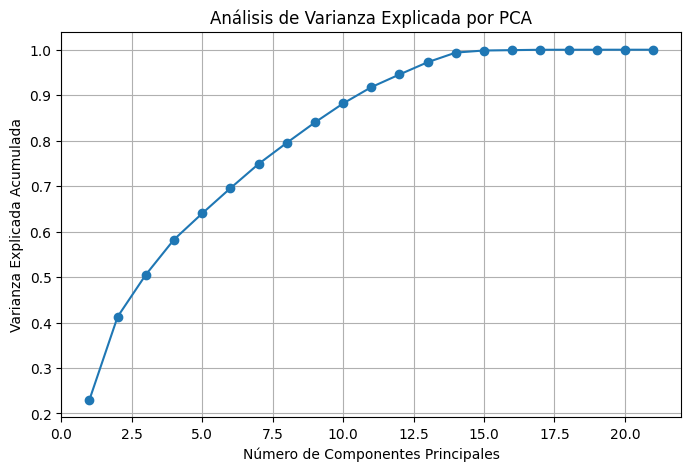

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculamos la varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Graficamos
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Análisis de Varianza Explicada por PCA')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import lightgbm as lgb

def run_pca_experiment(df, variance_threshold=0.95):


    # Columnas que no usaremos para PCA
    exclude_cols = [
        'severity_encoded', 'tramp_id', 'capture_count', 
        'month', 'year-month', 'sampling_date', 'municipality', 'state'
    ]

    # Features numericos a usar
    numerical_features = [
        'lat', 'lon', 'plantation_age', 'square_area_imputed', 'year',
        'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos',
        'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
        'distance_to_nearest_hotspot', 'hotspots_within_5km',
        'precipitation', 'avg_temp', 'max_temp', 'min_temp'
    ]

    # Features categoricos a usar
    categorical_features = ['critical_season']

    # Definimos nuestras entradas y salidas
    X = df[numerical_features + categorical_features]
    y = df['severity_encoded']

    # One-hot encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat = encoder.fit_transform(X[categorical_features])
    X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_features), index=X.index)

    # Escalado numérico
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X[numerical_features])
    X_num_df = pd.DataFrame(X_num_scaled, columns=numerical_features, index=X.index)

    # Combinar todo en un dataframe
    X_scaled = pd.concat([X_num_df, X_cat_df], axis=1)
    print(f"✅ Matriz final para PCA: {X_scaled.shape[1]} features")

    # Aplicamos PCA
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X_scaled)
    X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=X.index)

    print(f"PCA redujo las dimensiones a: {pca.n_components_} componentes")
    print(f"Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}")

    # Usamos los 2 primeros componentes que tienen mas impacto en las agrupaciones
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=X_pca_df.join(y),
        x='PC1', y='PC2',
        hue=y,
        palette='viridis',
        alpha=0.7
    )
    plt.title("Distribución de la Severidad en los 2 Primeros Componentes PCA")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.legend(title='Severity Encoded')
    plt.show()

    # Entrenamos nuestro LightGBM sencillo sobre los nuevos componentes
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca_df, y, test_size=0.3, random_state=42, stratify=y
    )

    model_pca = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=4,
        class_weight='balanced',
        random_state=42,
        device_type='gpu'
    )

    model_pca.fit(X_train, y_train)
    y_pred = model_pca.predict(X_test)

    # Metricas de evaluacion
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"\n Resultados del modelo PCA-LightGBM:")
    print(f"   Accuracy: {acc:.4f}")
    print(f"   F1_macro: {f1:.4f}")
    print("\n\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Matriz de confusión
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
    plt.title("Matriz de Confusión - Modelo PCA + LightGBM")
    plt.show()

    # Devolvemos un resumen de PCA
    results = {
        "pca_components": pca.n_components_,
        "explained_variance": pca.explained_variance_ratio_.sum(),
        "accuracy": acc,
        "f1_macro": f1,
        "model": model_pca,
        "X_pca_df": X_pca_df
    }

    return results

In [ ]:
results = run_pca_experiment(df)

print(f"\nResumen:")
print(f" - Componentes PCA: {results['pca_components']}")
print(f" - Varianza explicada: {results['explained_variance']:.2%}")
print(f" - Accuracy: {results['accuracy']:.4f}")
print(f" - F1_macro: {results['f1_macro']:.4f}")


# t-SNE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import warnings

def run_tsne_optimize_perplexity(df, numerical_features, categorical_features,
                                 target_col='severity_encoded', sample_size=40000,
                                 perplexity_values=[10, 20, 30, 40, 50],
                                 learning_rate=200, n_iter=1000):

    # Silenciar warnings innecesarios de t-SNE
    warnings.filterwarnings("ignore", category=UserWarning)

    # Uso de muestra o no
    if len(df) > sample_size:
        frac = sample_size / len(df)
        df_sample = df.sample(n=sample_size, random_state=42)
        print( f"Usando muestra del {frac:.1%} ({sample_size:,} filas).")
    else:
        df_sample = df.copy()
        print(f"✅ Dataset pequeño ({len(df):,} filas). No se aplica muestreo.")

    X = df_sample[numerical_features + categorical_features]
    y = df_sample[target_col]

    # Escalamos y encodeamos nuestro dataset o muestra
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    X_cat = encoder.fit_transform(X[categorical_features])
    X_cat_df = pd.DataFrame(
        X_cat, columns=encoder.get_feature_names_out(categorical_features), index=X.index
    )

    # Aplicamos el scaler
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X[numerical_features])
    X_num_df = pd.DataFrame(X_num_scaled, columns=numerical_features, index=X.index)

    X_scaled = pd.concat([X_num_df, X_cat_df], axis=1)

    
    # Array para comparar resultados por cada perplexity probado
    results = []

    for p in perplexity_values:
        print(f"Probando perplexity={p}")
        
        tsne = TSNE(
            n_components=2, # Plano 2D
            perplexity=p,
            learning_rate=learning_rate,
            max_iter=n_iter,
            random_state=42,
            verbose=0
        )

        X_embedded = tsne.fit_transform(X_scaled)
        tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
        score = silhouette_score(X_embedded, y)
        results.append({'perplexity': p, 'silhouette_score': score})

    # Comparación de resultados segun el silhouette score
    # tomamos el score mas alto
    results_df = pd.DataFrame(results)
    best = results_df.loc[results_df['silhouette_score'].idxmax()]
    best_p = best['perplexity']
    print(f"\n\nMejor perplexity: {best_p} (Silhouette={best['silhouette_score']:.4f})")

    # Generamos el mejor modelo TSNE con base en el silhouette score
    tsne_best = TSNE(
        n_components=2,
        perplexity=best_p,
        learning_rate=learning_rate,
        n_iter=n_iter,
        random_state=42,
        verbose=1
    )

    X_best = tsne_best.fit_transform(X_scaled)
    tsne_best_df = pd.DataFrame(X_best, columns=['Dim1', 'Dim2'])
    tsne_best_df[target_col] = y.values

    # Generamos el scatterplot para ver la distribucion en 2D
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=tsne_best_df,
        x='Dim1', y='Dim2',
        hue=target_col,
        palette='viridis',
        alpha=0.7,
        s=15
    )
    plt.title(f"t-SNE con mejor perplexity={best_p} | Silhouette={best['silhouette_score']:.4f}")
    plt.xlabel("Dimensión 1 (t-SNE)")
    plt.ylabel("Dimensión 2 (t-SNE)")
    plt.legend(title=target_col)
    plt.show()

    # Obtenemos resultados
    best_result = {
        "best_perplexity": best_p,
        "best_score": best['silhouette_score'],
        "results_df": results_df,
        "embedding_df": tsne_best_df
    }

    return [best_result , tsne_df]


In [ ]:
tsne_optimized, tsne_dataFrame = run_tsne_optimize_perplexity(
    df=df,
    numerical_features=numerical_features,
    categorical_features=categorical_features,
    target_col='severity_encoded',
    sample_size=40000,
    perplexity_values=[10, 20, 30, 40, 50],
    n_iter=1000
)


⚠️ Dataset grande detectado (827,856 muestras). Usando muestra del 4.8% (40,000 filas).
Probando perplexity=10
Probando perplexity=20
Probando perplexity=30
Probando perplexity=40
